Load Dataset

In [200]:
#Load files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = pd.read_excel("Prices.xlsx", engine = "openpyxl") #Read file
df = df.dropna()  #Clean dataset
df.head()

,Date,NPN,SBK,ANG,SHP,INL,SOL,IMP,GRT,APN,BVT
0,2000-01-04,28583529.76,2812.47,14089.40,900,3123.64,4950,1596.64,402.95,402.95,1596.64
1,2000-01-05,28002169.83,2823.71,13995.79,900,3125.95,4905,1567.22,402.95,402.95,1567.22
2,2000-01-06,27614596.55,2778.72,14042.59,870,3098.29,4980,1567.22,393.12,393.12,1567.22
3,2000-01-07,28922656.38,2834.96,14697.92,870,3112.12,5190,1580.60,417.69,417.69,1580.60
4,2000-01-10,30763629.49,3149.96,15212.81,870,3197.41,5300,1604.67,437.35,437.35,1604.67


### Perform EDA

                NPN      SBK      ANG      SHP      INL      SOL      IMP  \
count       6619.00  6619.00  6619.00  6619.00  6619.00  6619.00  6619.00   
mean   530220883.46 11526.28 25585.18 11534.96  4656.32 27519.37  9647.73   
min            0.00     0.00     0.00   500.00   881.77  2188.00  1068.25   
25%     33445152.15  8066.71 17124.00  2350.00  2725.98 13035.50  2533.98   
50%    171501178.56 11272.00 25929.00 12566.00  3776.61 27840.00  5557.40   
75%   1071590000.00 15300.00 31200.50 18082.50  5559.45 38665.00 17841.00   
max   1982852450.00 25042.00 86320.00 31452.00 14224.00 64510.00 29488.00   
std    607402133.53  5348.82 10718.40  8778.24  2917.78 14399.31  8587.47   

           GRT      APN      BVT  
count  6619.00  6619.00  6619.00  
mean  12881.71 12881.71  9647.73  
min     393.12   393.12  1068.25  
25%    3164.62  3164.62  2533.98  
50%   10324.00 10324.00  5557.40  
75%   20101.00 20101.00 17841.00  
max   44300.00 44300.00 29488.00  
std   11075.40 11075.40  8

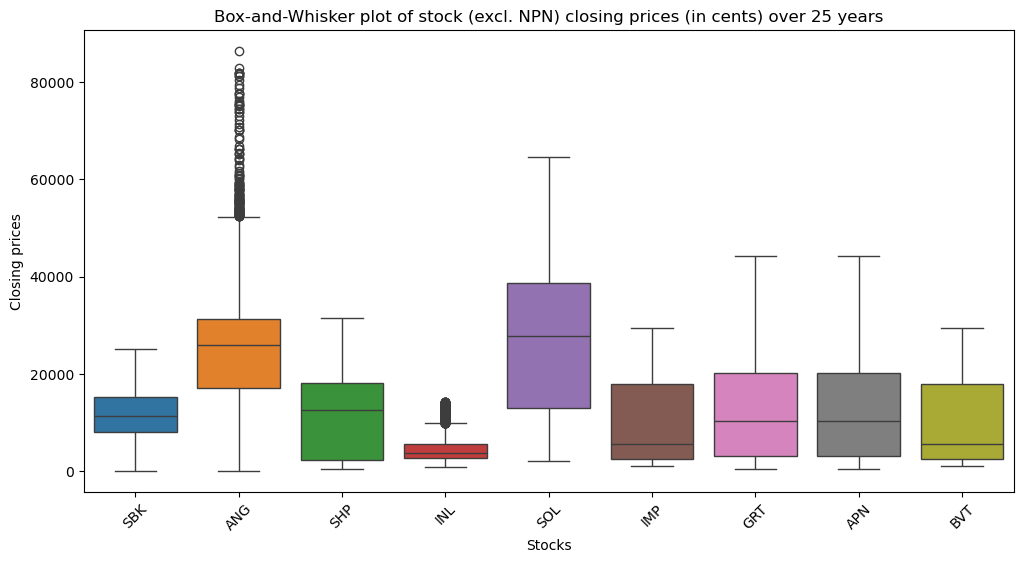

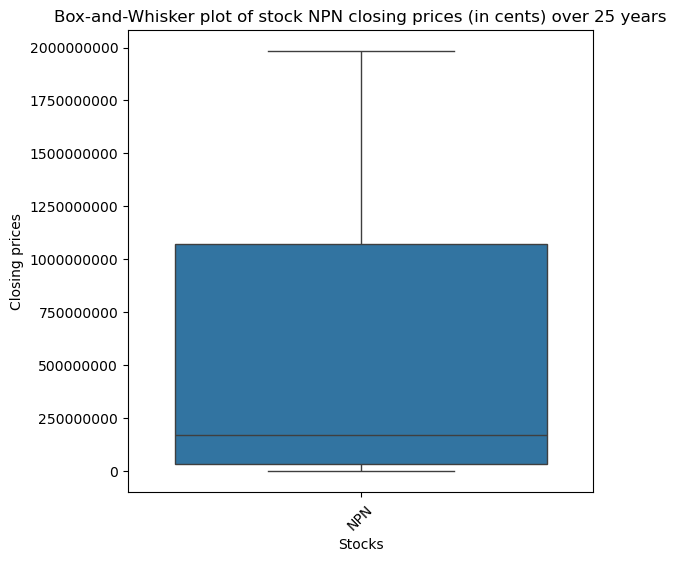

In [121]:
#5-number summary, and
#Box-and-whisker plots

pd.set_option('display.float_format', '{:.2f}'.format)  # Limits to 2 decimal places
print(df.describe().iloc[:, 1:]) #excludes the first column, i.e. date

plt.figure(figsize = (12, 6)) #Plot size: 12 inches wide and 6 inches tall
sns.boxplot(data = df.iloc[:, 2:]) #Plots the stocks excluding NPN
plt.xlabel("Stocks")
plt.ylabel("Closing prices")
plt.title("Box-and-Whisker plot of stock (excl. NPN) closing prices (in cents) over 25 years")
plt.xticks(rotation = 45)
plt.show()

#For Naspers
plt.figure(figsize = (6, 6))
sns.boxplot(data = df.iloc[:, :2]) #Plots the stocks excluding NPN
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
plt.xlabel("Stocks")
plt.ylabel("Closing prices")
plt.title("Box-and-Whisker plot of stock NPN closing prices (in cents) over 25 years")
plt.xticks(rotation = 45)
plt.show()

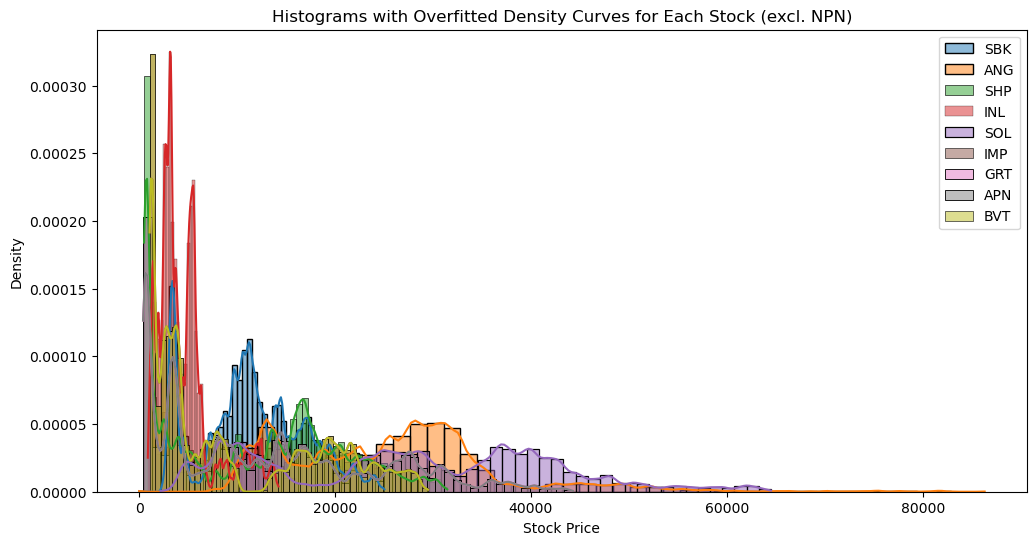

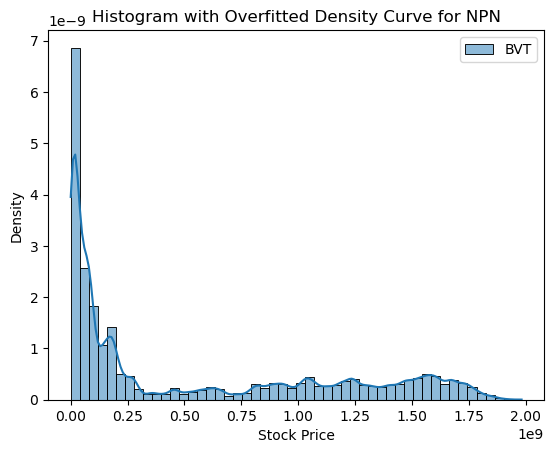

In [106]:
#Histogram with density curves
plt.figure(figsize=(12, 6))

# Loop through each stock column and plot its histogram with Kernel Desnity Estimation (KDE)
for col in df.columns[2:]:  # Assuming first column is Date and was removed
    sns.histplot(df[col], kde=True, bins=50, stat="density", kde_kws={"bw_adjust": 0.2}, label=col)

plt.xlabel("Stock Price")
plt.ylabel("Density")
plt.title("Histograms with Overfitted Density Curves for Each Stock (excl. NPN)")
plt.legend()
plt.show()

#For Naspers
sns.histplot(df[df.columns[1:2]], kde=True, bins=50, stat="density", kde_kws={"bw_adjust": 0.2}, label=col)

plt.xlabel("Stock Price")
plt.ylabel("Density")
plt.title("Histogram with Overfitted Density Curve for NPN")
plt.legend()
plt.show()

<Axes: >

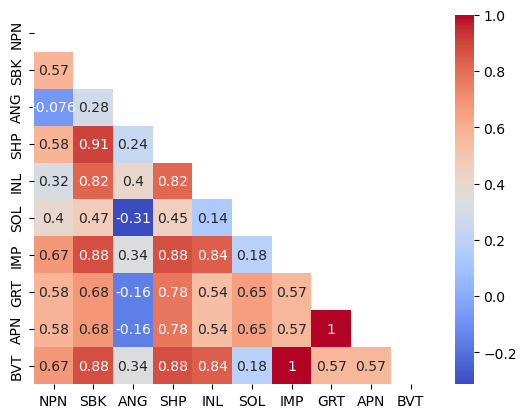

In [122]:
#Correlation Heatmap
dff = df.iloc[:, 1:] #omitts date column
sns.heatmap(dff.corr(), mask = np.triu(np.ones_like(dff.corr(), dtype = bool)), annot = True, cmap = "coolwarm")


#### Time Series EDA

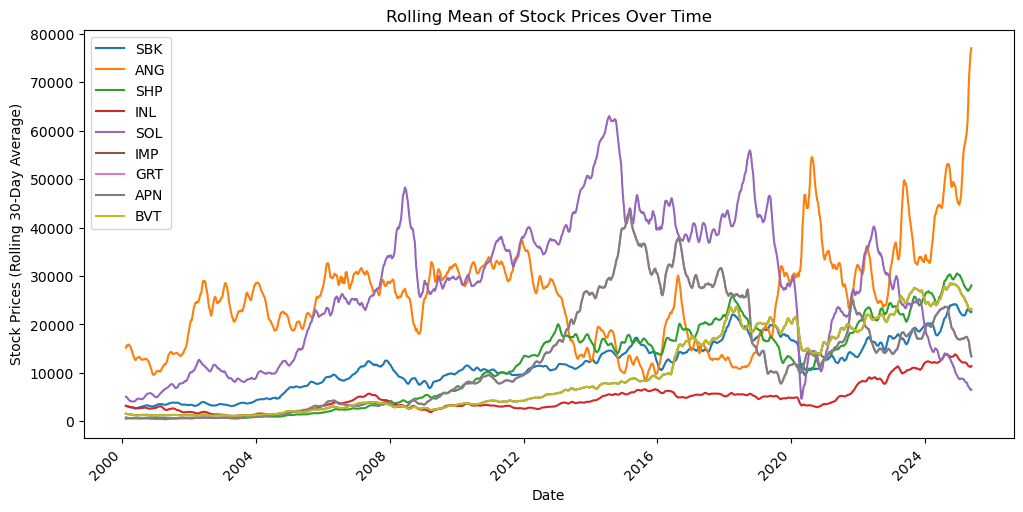

Text(0.5, 1.0, 'Rolling Mean of NPN Over Time')

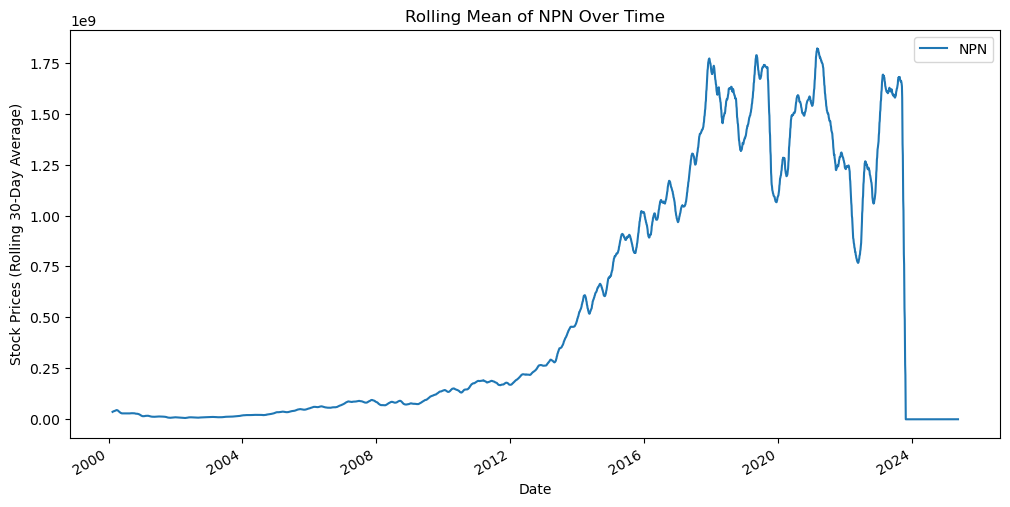

In [142]:
# Line trends
dff = df.copy() #Not corrupt data
dff.set_index(dff.columns[0], inplace=True)  # Set first column as index (Date)
dff.iloc[:, 1:].rolling(window=30).mean().plot(figsize=(12, 6))

plt.xlabel("Date")  # Label x-axis
plt.ylabel("Stock Prices (Rolling 30-Day Average)")
plt.title("Rolling Mean of Stock Prices Over Time")

plt.xticks(rotation=45)  # Improve readability of Date labels
plt.show()

dff.iloc[:, :-9].rolling(window=30).mean().plot(figsize=(12, 6))
plt.ylabel("Stock Prices (Rolling 30-Day Average)")
plt.title("Rolling Mean of NPN Over Time")

### Model Fitting

In [177]:
#Dickey-Fuller Test
for col in df.columns[1:]: 
    result = adfuller(df[col])
    print(f" P-value for {col} : {result[1]}")

 P-value for NPN : 0.40844237983614373
 P-value for SBK : 0.7646722280565463
 P-value for ANG : 0.8047044718552934
 P-value for SHP : 0.9116593583628814
 P-value for INL : 0.9788200548039114
 P-value for SOL : 0.35441234990495996
 P-value for IMP : 0.9270239855225724
 P-value for GRT : 0.5439855469760666
 P-value for APN : 0.5439855469760666
 P-value for BVT : 0.9270239855225724


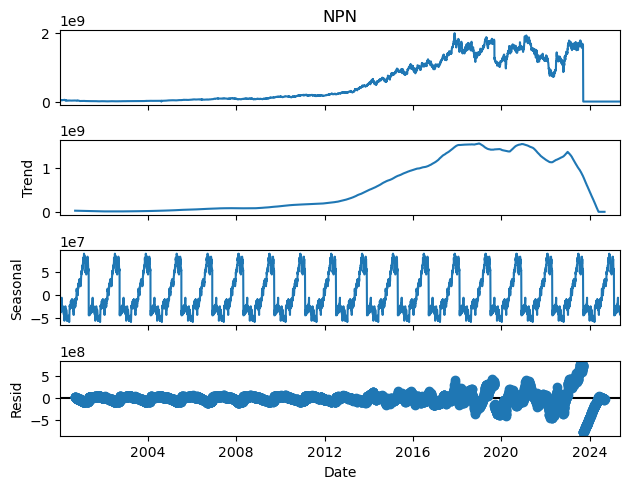

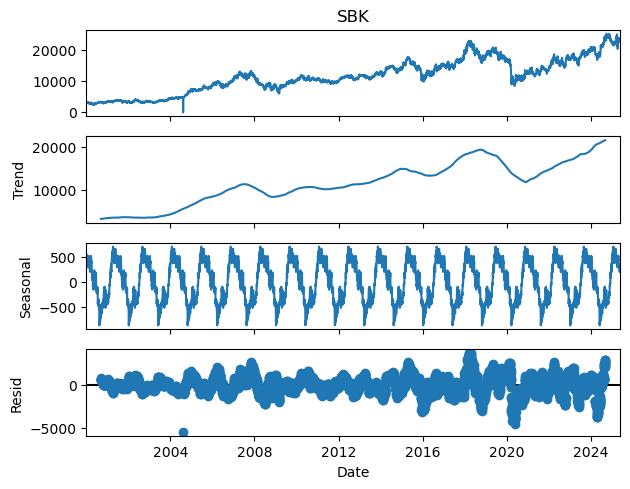

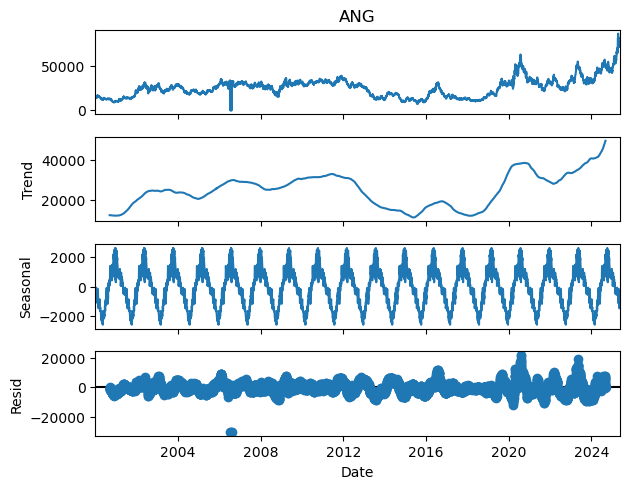

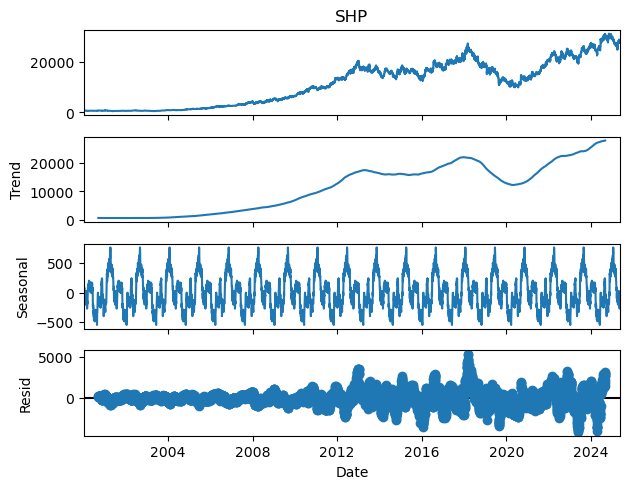

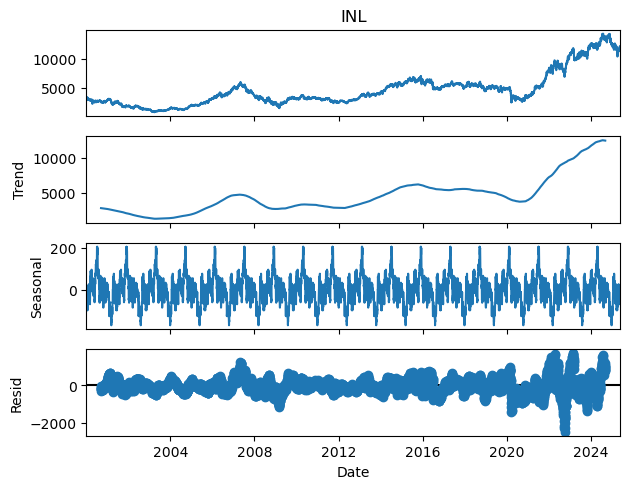

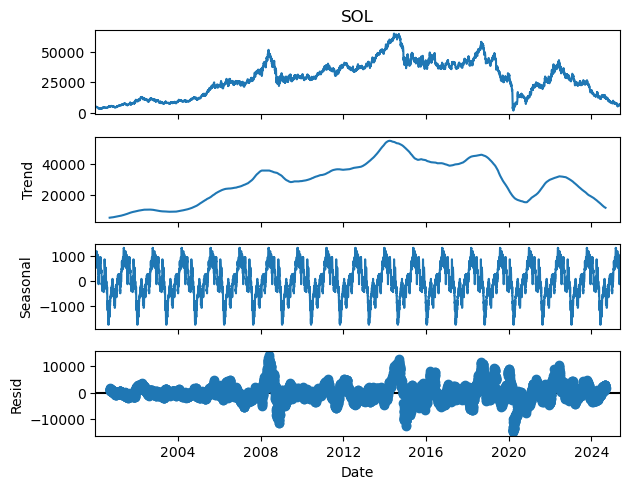

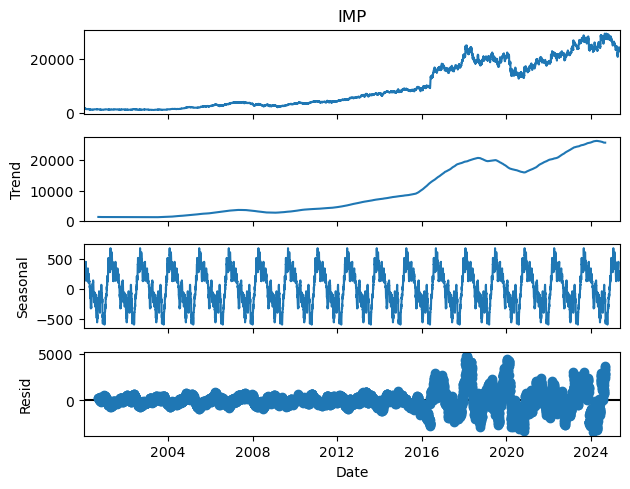

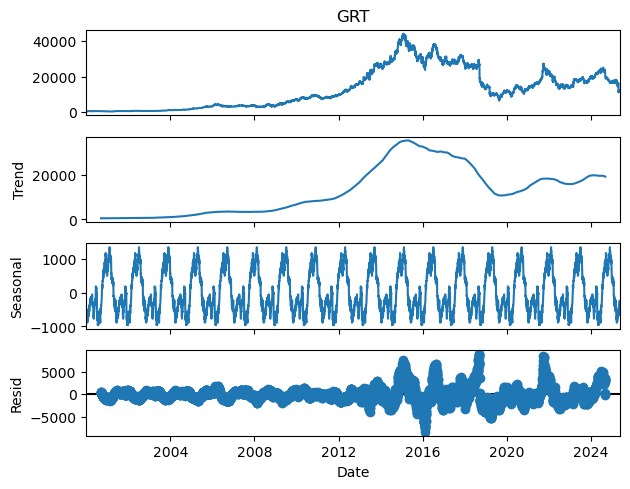

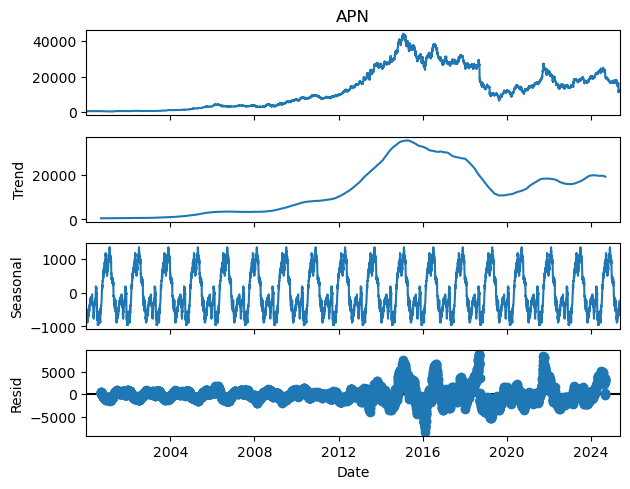

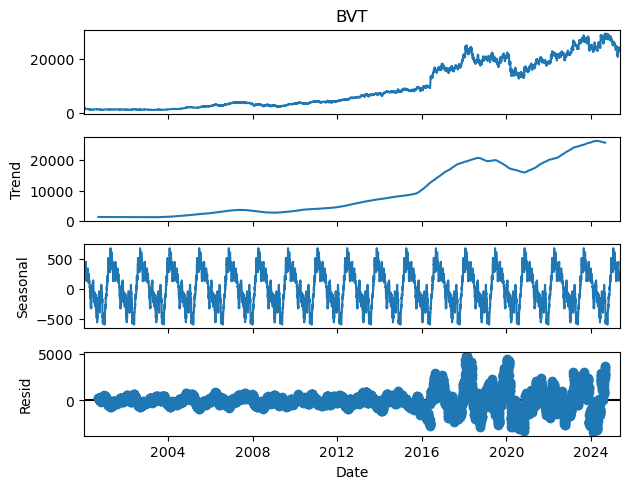

In [202]:
# Decomposition into trend, seasonality and residuals

for col in df.columns[1:]: 
    decomposition = seasonal_decompose(dff[col], period=365)
    decomposition.plot()
    plt.xlabel("Date")


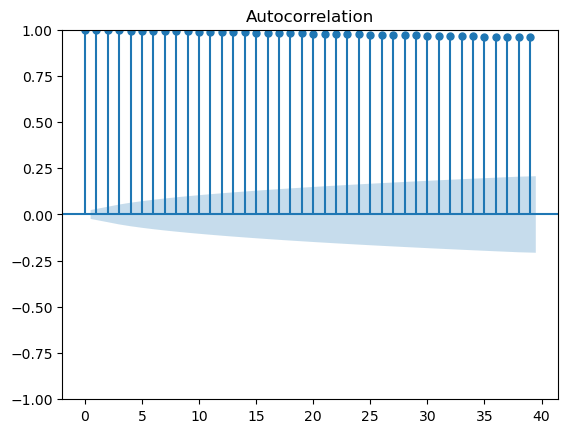

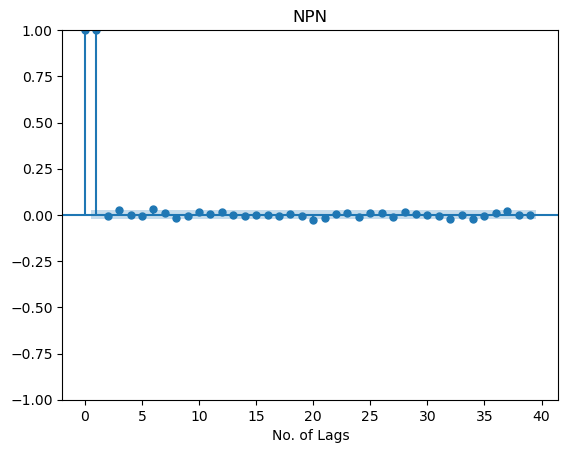

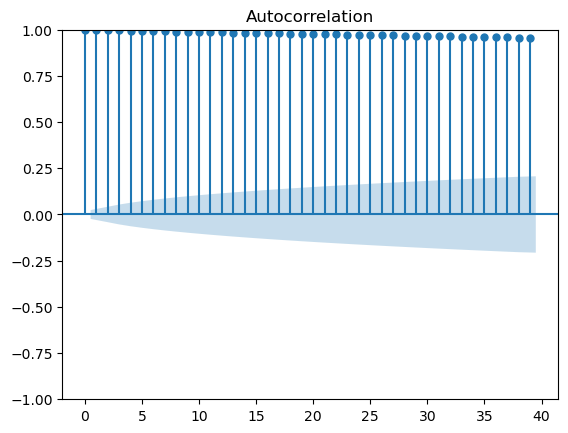

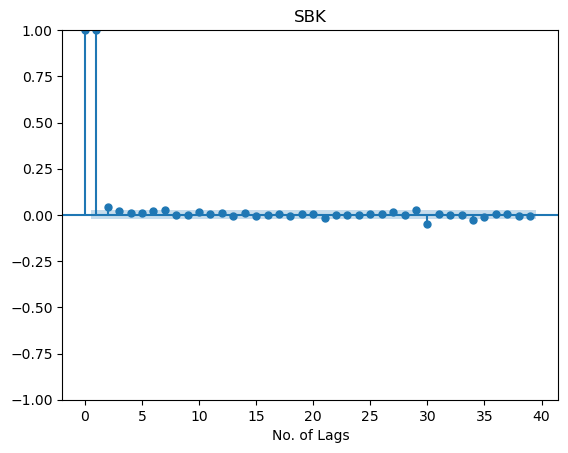

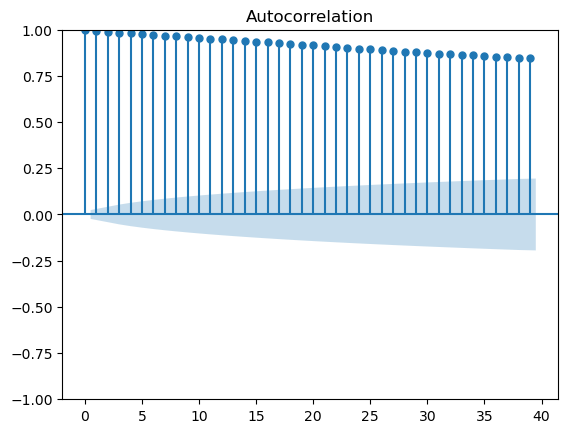

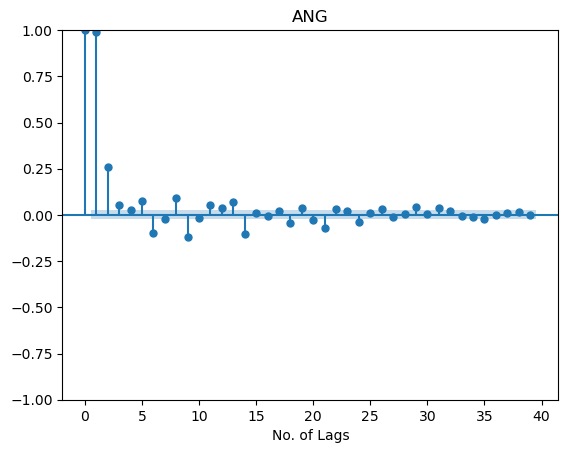

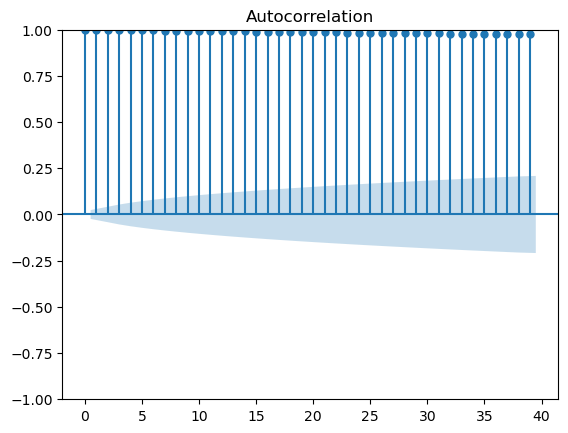

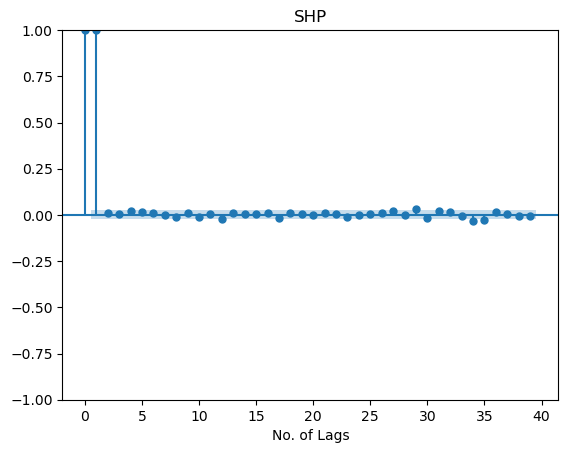

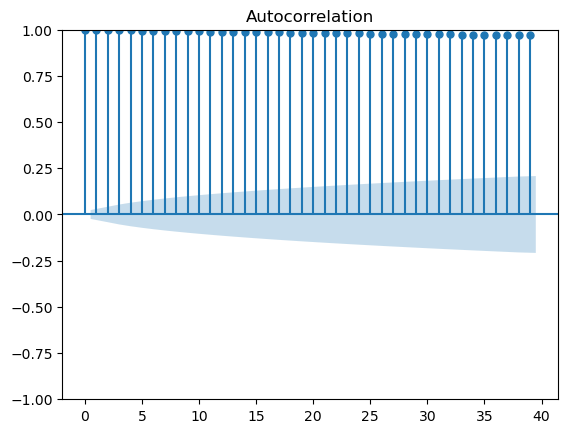

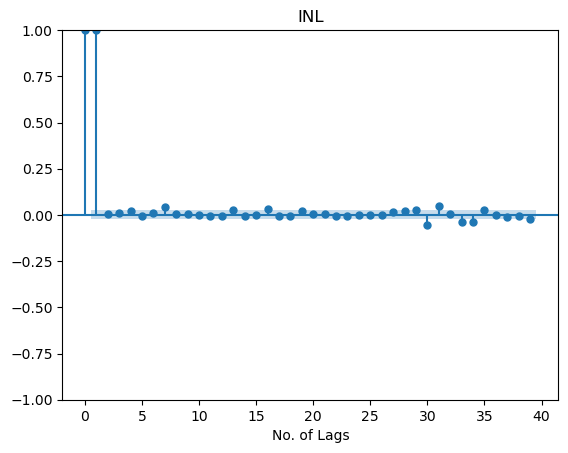

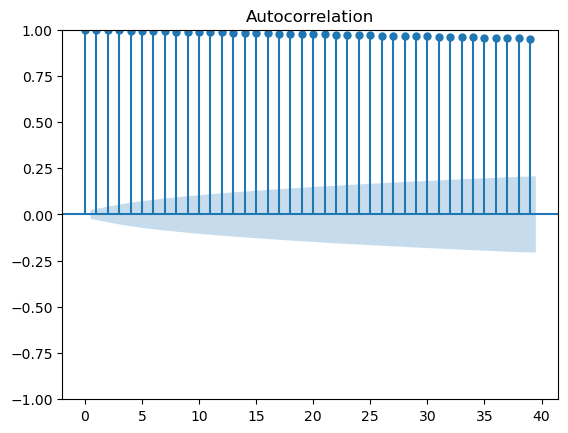

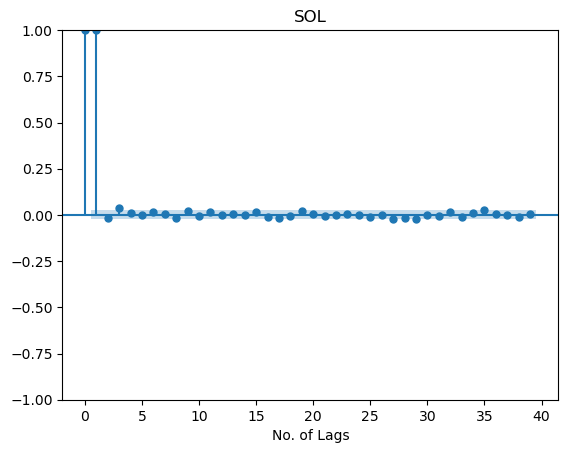

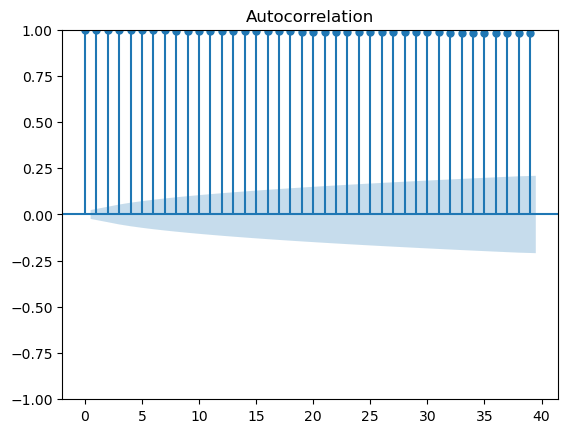

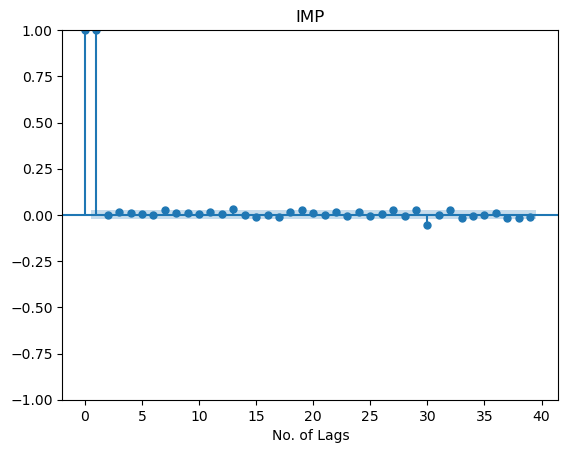

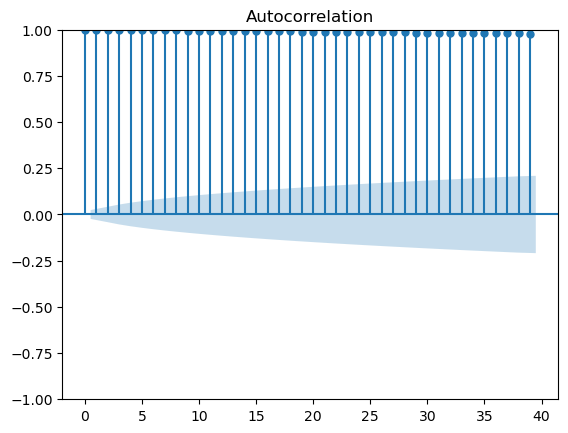

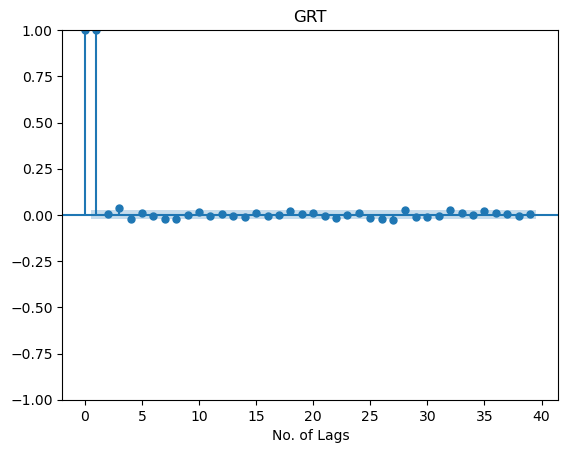

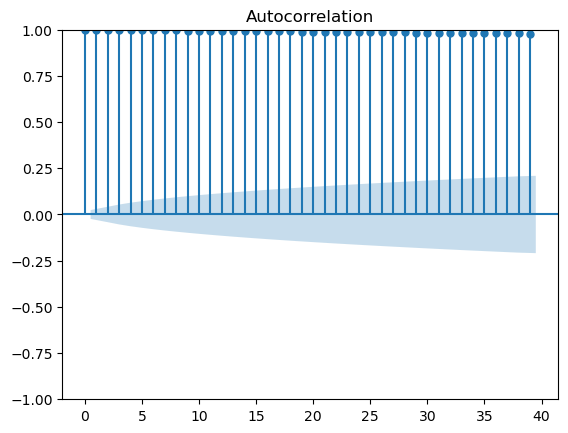

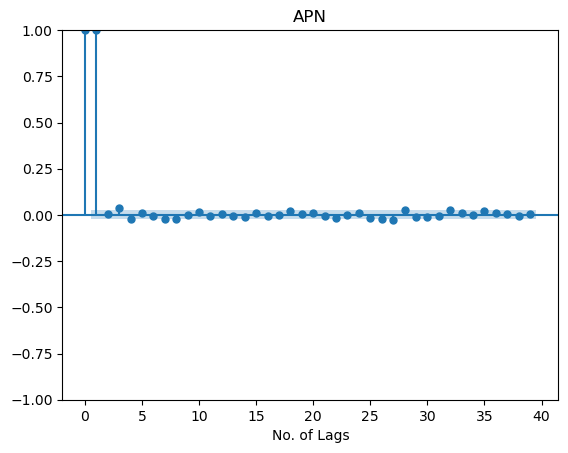

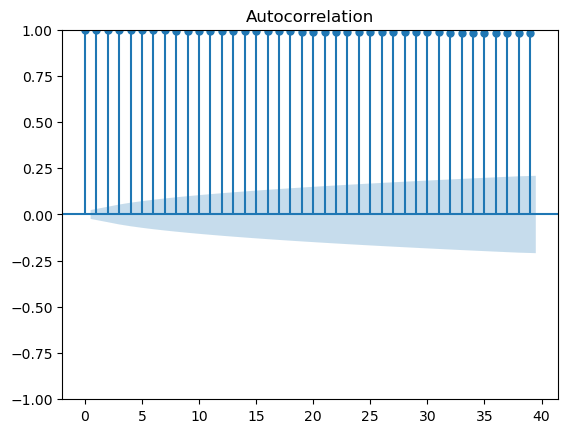

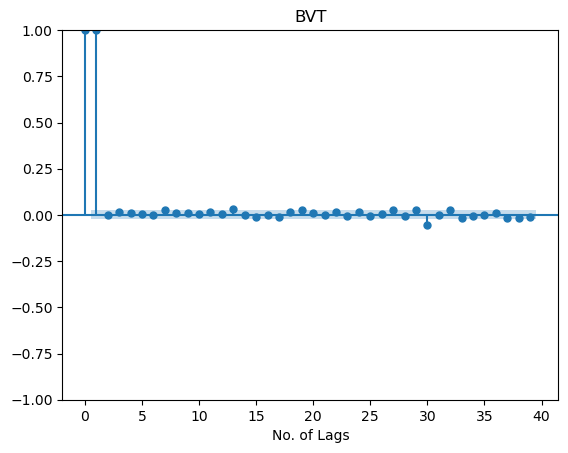

In [206]:
# Auto-Correlation Function (ACF) and Partial Auto-Correlation (PACF)
for col in df.columns[1:]:
    plot_acf(dff[col])
    plot_pacf(dff[col])
    plt.title(col)
    plt.xlabel("No. of Lags")